In [1]:
## Standard libraries
import os
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
## Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
# # Download a pretrained model.
# if not os.path.exists('saved_models'):
#     os.mkdir('saved_models')
# !wget -O 'saved_models/model.pth' https://raw.githubusercontent.com/david-knigge/uvadlc2-tutorial-Gumbel-Sinkhorn-Networks/main/model.pth

import urllib.request

if not os.path.exists('saved_models'):
    os.mkdir('saved_models')

url = 'https://raw.githubusercontent.com/david-knigge/uvadlc2-tutorial-Gumbel-Sinkhorn-Networks/main/model.pth'
urllib.request.urlretrieve(url, 'saved_models/model.pth')

('saved_models/model.pth', <http.client.HTTPMessage at 0x21ae5fd8670>)

In [3]:

# Path to the folder where the datasets are be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
def log_sinkhorn(log_alpha, n_iter):
    """Performs incomplete Sinkhorn normalization to log_alpha.
    By a theorem by Sinkhorn and Knopp [1], a sufficiently well-behaved  matrix
    with positive entries can be turned into a doubly-stochastic matrix
    (i.e. its rows and columns add up to one) via the successive row and column
    normalization.

    [1] Sinkhorn, Richard and Knopp, Paul.
    Concerning nonnegative matrices and doubly stochastic
    matrices. Pacific Journal of Mathematics, 1967
    Args:
      log_alpha: 2D tensor (a matrix of shape [N, N])
        or 3D tensor (a batch of matrices of shape = [batch_size, N, N])
      n_iters: number of sinkhorn iterations (in practice, as little as 20
        iterations are needed to achieve decent convergence for N~100)
    Returns:
      A 3D tensor of close-to-doubly-stochastic matrices (2D tensors are
        converted to 3D tensors with batch_size equals to 1)
    """
    for _ in range(n_iter):
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -1, keepdim=True)
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -2, keepdim=True)
    return log_alpha.exp()

In [5]:
# Create a matrix containing random numbers.
X = torch.rand((3, 3))
X

tensor([[0.5344, 0.3199, 0.1781],
        [0.7043, 0.2814, 0.4743],
        [0.1637, 0.7063, 0.9338]])

In [6]:
# Apply the Sinkhorn operator for 20 iterations.
S_X = log_sinkhorn(torch.log(X), n_iter=20)
S_X

tensor([[0.4738, 0.3528, 0.1734],
        [0.4471, 0.2223, 0.3307],
        [0.0792, 0.4249, 0.4959]])

In [7]:
# Check whether rows sum to 1.
assert torch.allclose(S_X.sum(dim=0), torch.ones(S_X.shape[0]))

# Check whether columns sum to 1.
assert torch.allclose(S_X.sum(dim=1), torch.ones(S_X.shape[1]))

In [8]:
## Scipy
from scipy.optimize import linear_sum_assignment
from scipy.sparse import coo_matrix


def matching(alpha):
    # Negate the probability matrix to serve as cost matrix. This function
    # yields two lists, the row and colum indices for all entries in the
    # permutation matrix we should set to 1.
    row, col = linear_sum_assignment(-alpha)

    # Create the permutation matrix.
    permutation_matrix = coo_matrix((np.ones_like(row), (row, col))).toarray()
    return torch.from_numpy(permutation_matrix)

# Example usage:
temp = torch.rand((3, 3))
matching(temp)

In [9]:
matching(S_X)

tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 0, 1]])

In [10]:
def sample_gumbel(shape, device='cpu', eps=1e-20):
    """Samples arbitrary-shaped standard gumbel variables.
    Args:
      shape: list of integers
      eps: float, for numerical stability
    Returns:
      A sample of standard Gumbel random variables
    """
    u = torch.rand(shape, device=device)
    return -torch.log(-torch.log(u + eps) + eps)

In [11]:
sample_gumbel((3, 3))

tensor([[ 0.3005,  1.9939,  1.9028],
        [ 1.6983, -0.3521, -0.0660],
        [-0.7222,  0.2397, -1.2841]])

In [12]:
def gumbel_sinkhorn(log_alpha, tau, n_iter):
    """ Sample a permutation matrix from the Gumbel-Sinkhorn distribution
    with parameters given by log_alpha and temperature tau.

    Args:
      log_alpha: Logarithm of assignment probabilities. In our case this is
        of dimensionality [num_pieces, num_pieces].
      tau: Temperature parameter, the lower the value for tau the more closely
        we follow a categorical sampling.
    """
    # Sample Gumbel noise.
    gumbel_noise = sample_gumbel(log_alpha.shape, device=log_alpha.device)

    # Apply the Sinkhorn operator!
    sampled_perm_mat = log_sinkhorn((log_alpha + gumbel_noise) / tau, n_iter)
    return sampled_perm_mat

In [13]:
# For low values of tau the sampled matrices are closer to actual
# permutation matrices.
gumbel_sinkhorn(X, tau=0.01, n_iter=20)

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00],
        [6.2878e-03, 0.0000e+00, 1.0000e+00],
        [9.9371e-01, 7.6687e-31, 3.0753e-10]])

In [14]:
# For higher values of tau the sampled matrices are 'less categorical'
gumbel_sinkhorn(X, tau=10, n_iter=20)

tensor([[0.2862, 0.3914, 0.3223],
        [0.3834, 0.2878, 0.3288],
        [0.3304, 0.3207, 0.3489]])

In [15]:
# Create a matrix containing random numbers. Let PyTorch know we want gradients.
X = torch.rand((3, 3), requires_grad=True)

# Sample a permutation matrix from the Gumbel-Sinkhorn distribution.
P = gumbel_sinkhorn(X * 1000, tau=1, n_iter=2000)
P.sum().backward()

X.grad

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -2.6581e-21,  2.6581e-21],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [78]:
import torch
import torch.nn as nn


class SinkhornConvNet(nn.Module):
    def __init__(
            self,
            in_channels: int,
            num_pieces: int,
            image_size: int,
            hidden_channels: int,
            kernel_size: int,
            tau: float = 1.0,
            n_sink_iter: int = 20,
    ):
        super().__init__()

        # store these for later use.
        self.tau = tau
        self.n_sink_iter = n_sink_iter

        self.g_1 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size, padding=kernel_size // 2),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.BatchNorm2d(hidden_channels)
        )

        # calculate the size of a single piece in pixels
        piece_size = image_size // num_pieces

        # calculate the size of a single piece in pixels after 1 max pooling
        piece_size_after_conv = (piece_size) // (2 * 1)

        self.g_2 = nn.Linear(piece_size_after_conv ** 2 * hidden_channels, num_pieces ** 2, bias=False)

    def forward(self, batch_pieces):
        # in: (torch.Size([64, 4, 1, 14, 14]))
        # out: (torch.Size([64, 4, 1, 14, 14]), torch.Size([64, 4, 4]))
        batch_size = batch_pieces.shape[0]

        # Switch batch and piece dimensions. We want to apply the same network
        # to each of the pieces.
        pieces = batch_pieces.transpose(0, 1).contiguous()

        # Apply g_1 to each of the pieces.
        conv_pieces = []
        for piece in pieces:
            piece = self.g_1(piece)
            conv_piece = piece.reshape(batch_size, -1)
            conv_pieces.append(conv_piece)

        # Apply g_2 to each of the pieces.
        latent_pieces = []
        for piece in conv_pieces:
            latent_piece = self.g_2(piece)
            latent_pieces.append(latent_piece)
            print("latent_piece") # torch.Size([4, 64, 1, 14, 14]), torch.Size([64, 4])
            print(pieces.shape)
            print(latent_piece.shape)
            break
        

        # Create a matrix of log unnormalized assignment probabilities. After this
        # the batch dimension is batch in the first position.
        log_alphas = torch.stack(latent_pieces, 1)

        # During training, we sample from the Gumbel-Sinkhorn distribution.
        if self.training:
            permutation_matrices = gumbel_sinkhorn(log_alphas, tau=self.tau, n_iter=self.n_sink_iter)

        # During eval, we solve the linear assignment problem.
        else:
            permutation_matrices = torch.stack([
                matching(log_alpha)
                for log_alpha in log_alphas.cpu().detach().numpy()]
            ).float().to(log_alphas.device)

        # We obtain the ordered pieces as predicted by our network
        ordered_pieces = inverse_permutation_for_image(batch_pieces, permutation_matrices)

        # Return the ordered pieces, along with the predicted permutation.
        # We will inspect the predicted permutation matrices during test time.
        return ordered_pieces, permutation_matrices
    
# test
model = SinkhornConvNet(
    in_channels=1,
    num_pieces=2,
    image_size=28,
    hidden_channels=32,
    kernel_size=5,
    tau=0.1,
    n_sink_iter=20
).to(device)

random_pieces = torch.rand((64, 4, 1, 14, 14)).to(device)
res1, res2 = model(random_pieces)
res1.shape, res2.shape

latent_piece
torch.Size([4, 64, 1, 14, 14])
torch.Size([64, 4])


(torch.Size([64, 4, 1, 14, 14]), torch.Size([64, 1, 4]))

In [17]:
def chunk_image(image: torch.Tensor, num_pieces: int):
    """Randomly chunk a single image.
    Args:
      image: Image [channels, height, width].

    Returns:
      pieces: Image chunks in their original positions. [num_pieces, channels,
        height // num_pieces, width // num_pieces]
      random_pieces: Image chunks in their randomly permuted positions.
      permute_index: List of permuted indices.
    """
    # Get image dimensions.
    height, width = image.shape[-2:]

    # Get piece dimensions.
    piece_height = height // num_pieces
    piece_width = width // num_pieces
    pieces = []

    # Obtain indices for each of the image chunks.
    for p_h in range(num_pieces):
        for p_w in range(num_pieces):
            left = p_w * piece_width
            right = left + piece_width
            top = p_h * piece_height
            bottom = top + piece_height
            piece = image[:, top:bottom, left:right]
            pieces.append(piece)

    pieces = torch.stack(pieces, 0)

    # Randomly permute the index of the pieces.
    permute_index = torch.randperm(num_pieces ** 2)
    random_pieces = pieces[permute_index]
    return pieces, random_pieces, permute_index


def batch_chunk_image(images: torch.Tensor, num_pieces: int):
    """Randomly chunk a batch of images.
    Args:
      image: Images [batch, channels, height, width].

    Returns:
      pieces: Batch of image chunks in their original positions. [batch,
        num_pieces, channels, height // num_pieces, width // num_pieces]
      random_pieces: Batch of image chunks in their randomly permuted positions.
         [batch, num_pieces, channels, height // num_pieces, width // num_pieces]
      permute_index: Batch of permutation lists. [batch, num_pieces**2]
    """
    batch_pieces, batch_random_pieces, batch_permute_index = [], [], []
    for image in images:
        pieces, random_pieces, permute_index = chunk_image(image, num_pieces)

        batch_pieces.append(pieces)
        batch_random_pieces.append(random_pieces)
        batch_permute_index.append(permute_index)
    return torch.stack(batch_pieces, 0), torch.stack(batch_random_pieces, 0), torch.stack(batch_permute_index, 0)


def inverse_permutation_for_image(X, permutation_matrix):
    """Apply the inverse of a permutation (its transpose) to a batch of image
       chunks.
    Args:
      X: Batched sets of image chunks. [batch, num_pieces, channels, height, width]
      permutation_matrix: float, for numerical stability

    Returns:
      Permuted set of image chunks.
    """
    return torch.einsum("bpq,bpchw->bqchw", (permutation_matrix, X)).contiguous()

In [18]:
from torchvision import datasets
from torchvision import transforms

from torch import optim
from torch.utils.data import DataLoader

device = torch.device('cuda')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(trainset, 64, drop_last=True, shuffle=True)
test_loader = DataLoader(testset, 64, drop_last=False, shuffle=True)

In [53]:
image_batch, _ = next(iter(test_loader))

# Chunk the images into 2 pieces
num_pieces = 2

# Select an image from the batch
batch_idx = 0

pieces, random_pieces, perm_list = batch_chunk_image(image_batch, num_pieces=num_pieces)
pieces, random_pieces = pieces.to(device), random_pieces.to(device)

torch.Size([64, 1, 28, 28])
torch.Size([64, 4, 1, 14, 14])
torch.Size([64, 4, 1, 14, 14])


In [66]:
# res1, res2 = model(random_pieces)
# res1.shape, res2.shape

print(image_batch.shape)
print(pieces.shape)
print(random_pieces.shape)

model.train()
res1, res2 = model(random_pieces)

torch.Size([64, 1, 28, 28])
torch.Size([64, 4, 1, 14, 14])
torch.Size([64, 4, 1, 14, 14])


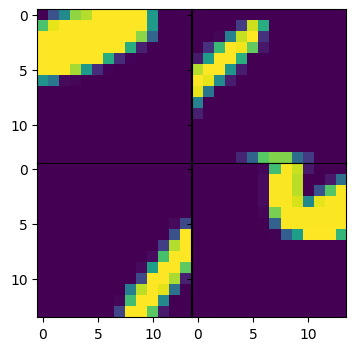

In [67]:
# Plot the original scrambed image.
figs, axs = plt.subplots(num_pieces, num_pieces, figsize=(4, 4), sharex=True, sharey=True)
for idx, piece in enumerate(random_pieces[batch_idx]):
    axs[idx // num_pieces, idx % num_pieces].imshow(piece.cpu().squeeze())

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [21]:
tau = 0.1  # Temperature parameter.
n_sink_iter = 20  # Number of iterations of Sinkhorn operator.

num_pieces = 2  # Number of pieces each side.
image_size = 28  # Original image size.

in_channels = 1
hidden_channels = 32
kernel_size = 5

epochs = 5
learning_rate = 1e-4
train = False  # Set this to false if you only want to evaluate the model

In [22]:
model = SinkhornConvNet(
    in_channels=in_channels,
    num_pieces=num_pieces,
    image_size=image_size,
    hidden_channels=hidden_channels,
    kernel_size=kernel_size,
    tau=tau,
    n_sink_iter=n_sink_iter
).to(device)

optimizer = optim.Adam(model.parameters(), learning_rate, eps=1e-8)

In [23]:
if train:
    model.train()
    for epoch in range(epochs):
        sum_loss = 0
        for i, data in enumerate(train_loader):
            inputs, _ = data

            # Chunk the images into pieces
            pieces, random_pieces, _ = batch_chunk_image(inputs, num_pieces)
            pieces, random_pieces = pieces.to(device), random_pieces.to(device)

            # Predict the ordering of the pieces using the Sinkhorn Network
            # in: (batch, num_pieces**2, channels, height, width)
            # out: (batch, num_pieces**2, channels, height, width)
            ordered_pieces, _ = model(random_pieces)

            # Apply MSE Loss
            loss = torch.nn.functional.mse_loss(ordered_pieces, pieces, reduction='sum')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            sum_loss += loss.item()

        print(f"epoch {epoch}|  mean loss {round(sum_loss / len(train_loader.dataset), 4)}")

    if not os.path.exists('./saved_models/'):
        os.mkdir('./saved_models')
    torch.save(model.state_dict(), "./saved_models/model.pth")

In [73]:
# Scipy
from scipy.stats import kendalltau

model = SinkhornConvNet(
    in_channels=in_channels,
    num_pieces=num_pieces,
    image_size=image_size,
    hidden_channels=hidden_channels,
    kernel_size=kernel_size,
    tau=tau,
    n_sink_iter=n_sink_iter
).to(device)

model.load_state_dict(torch.load(os.path.join("./saved_models/model.pth")))
model = model.to(device)
model.eval()

with torch.no_grad():
    kendall_taus = []

    for data in test_loader:
        inputs, _ = data
        pieces, random_pieces, perm_list = batch_chunk_image(inputs, num_pieces)
        pieces, random_pieces = pieces.to(device), random_pieces.to(device)

        ordered_pieces, predicted_permutation_matrices = model(random_pieces)

        # Create the list of inverse permutation indices from the predicted
        # permutation matrix.
        predicted_perm_list = predicted_permutation_matrices.transpose(1, 2).max(1)[1]

        # Obtain the Kendall-Tau correlation coefficient for the target
        # and predicted list of permutation matrices.
        for p1, p2 in zip(perm_list, predicted_perm_list):
            kendall_taus.append(
                kendalltau(p1.cpu(), p2.cpu())[0]
            )

    print(f"Mean Kendall-Tau: {np.mean(kendall_taus)}")

Mean Kendall-Tau: 0.9930666666666667


In [74]:
image_batch, _ = next(iter(test_loader))
pieces, random_pieces, perm_list = batch_chunk_image(image_batch, num_pieces)
pieces, random_pieces = pieces.to(device), random_pieces.to(device)

# Make sure we are evaluating!
model.eval()

# Predict the correctly ordered pieces.
predicted_pieces, _ = model(random_pieces)

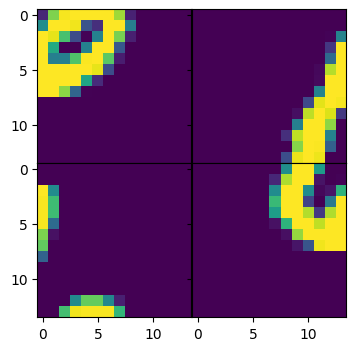

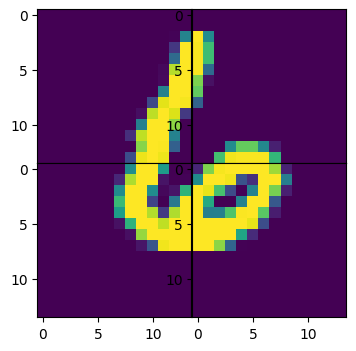

In [75]:
# Select an image from the batch.
batch_idx = 3

# Plot the original scrambed image.
figs, axs = plt.subplots(num_pieces, num_pieces, figsize=(4, 4), sharex=True, sharey=True)
for idx, piece in enumerate(random_pieces[batch_idx]):
    axs[idx // num_pieces, idx % num_pieces].imshow(piece.cpu().squeeze())
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Plot the predicted reconstructed image.
figs, axs = plt.subplots(num_pieces, num_pieces, figsize=(4, 4))
for idx, piece in enumerate(predicted_pieces[batch_idx]):
    axs[idx // num_pieces, idx % num_pieces].imshow(piece.cpu().squeeze())
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()